Enter the start date (YYYYMMDD):  20200101
Enter the end date (YYYYMMDD):  20240101
Enter a comma-separated list of stock tickers:  AAPL,NKE,GOOGL,AMZN


[*********************100%%**********************]  4 of 4 completed


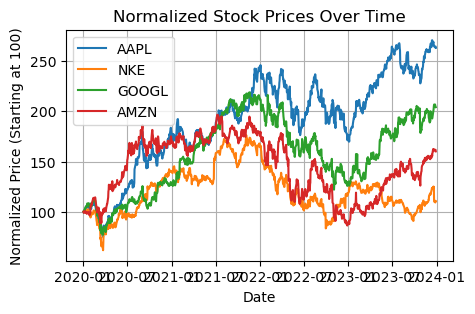

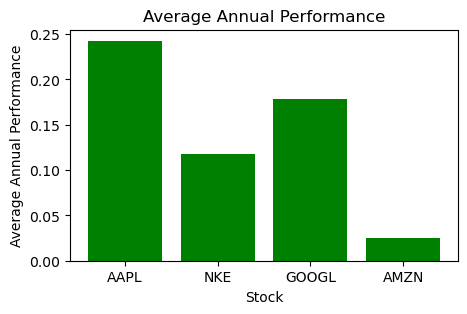

Covariance Matrix: Ticker      AAPL      AMZN     GOOGL       NKE
Ticker                                        
AAPL    0.000447  0.000314  0.000310  0.000256
AMZN    0.000314  0.000563  0.000335  0.000235
GOOGL   0.000310  0.000335  0.000447  0.000239
NKE     0.000256  0.000235  0.000239  0.000498


Enter number of samples for simulations (for example, 100000):  100000


Maximum Sharp: 97997

Performance expected: 26.3%
Volatility expected: 32.4%


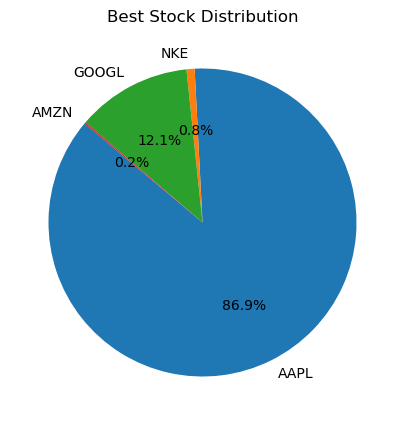

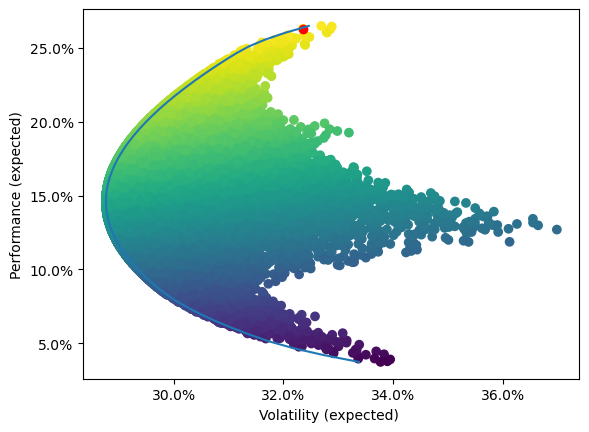

In [24]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
from scipy.optimize import minimize
import matplotlib.ticker as mtick

### inputing your requests

start_input = input("Enter the start date (YYYYMMDD): ")
end_input = input("Enter the end date (YYYYMMDD): ")

start = dt.datetime.strptime(start_input, "%Y%m%d").date()
end = dt.datetime.strptime(end_input, "%Y%m%d").date()

ticker_input = input("Enter a comma-separated list of stock tickers: ")

### Split the input string into a list of tickers
stock_list = [ticker.strip() for ticker in ticker_input.split(",")]

price = yf.download(stock_list, start, end)['Adj Close']

### show the normalized price line graph comparing the performance of each stock

normalized_prices = price / price.iloc[0] * 100

plt.figure(figsize=(5, 3))
for stock in stock_list:
    plt.plot(normalized_prices.index, normalized_prices[stock], label=stock)

plt.legend()
plt.xlabel('Date')
plt.ylabel('Normalized Price (Starting at 100)')
plt.title('Normalized Stock Prices Over Time')
plt.grid(True)

plt.show()

### daily logarithm performance

performance = price.pct_change().apply(lambda x: np.log(1+x)).dropna() 
performance_average = performance.mean()
annual_performance=performance_average*252

### annual performace print
'''
print("=" * 50)
print('Average Performance (daily):',performance_average)
'''
performance_summary = pd.DataFrame({'Stock': stock_list, 'Daily Perf.(ave)': performance_average,'Annual Perf.(ave)':annual_performance})
'''
print("=" * 50)
print (performance_summary)
'''

### showing the average performance barplot 

plt.figure(figsize=(5, 3))
plt.bar(performance_summary['Stock'],performance_summary['Annual Perf.(ave)'], color='green')

plt.xlabel('Stock')
plt.ylabel('Average Annual Performance')
plt.title('Average Annual Performance')

plt.show()

### covariance matrix (that will be used to calculate volatilities)
covariance_matrix = performance.cov() 
print("=" * 50)
print('Covariance Matrix:',covariance_matrix)
print("=" * 50)

### simulating n samples
samples = int(input("Enter number of samples for simulations (for example, 100000): "))
performance_expected = np.zeros(samples) #starts with zero because depends on weight for each stock
volatility_expected = np.zeros(samples)
sharpe = np.zeros(samples)
weight_tab = np.zeros((samples, len(stock_list))) #weight for each stock


### creating weight randomily for n samples
for k in range(samples):
    
    weights = np.random.random(len(stock_list))
    weights = weights/np.sum(weights)
    weight_tab[k, :] = weights
    
    performance_expected[k] = np.sum(performance_average * weights * 252) # annual performance, once it's a logarithm performance, we can simply *252
    volatility_expected[k] = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix*252, weights)))
    
    sharpe[k] = performance_expected[k]/volatility_expected[k]### best sharpe (higher performance with lower volatility) 

sharpe_max = sharpe.argmax()

# To print the sharp value
print("=" * 50)
print("Maximum Sharp:",sharpe_max)

### shoving the expected performance and volatility of the best sharpe

aritmetic_performance_expected = np.exp(performance_expected) - 1
print("Performance expected: {:.1%}".format(aritmetic_performance_expected[sharpe_max]))
print("Volatility expected: {:.1%}".format(volatility_expected[sharpe_max]))
print("=" * 50)

### To print weight for each stock
weight_summary = pd.DataFrame({'Stock': stock_list, 'Weight': weight_tab[sharpe_max]})
'''
print("=" * 50)
print (weight_summary)
'''

### Showing the best weight (distribuition) by piechart

plt.figure(figsize=(5, 5))
plt.pie(weight_summary['Weight'], labels=weight_summary['Stock'], autopct='%1.1f%%', startangle=140)

plt.title('Best Stock Distribution')

plt.show()

### drawing the curve of efficient board


efficient_frontier = np.linspace(aritmetic_performance_expected.min(), 
                                         aritmetic_performance_expected.max(), 50)

def return_data(weight_test):
    weight_test = np.array(weight_test)
    performance_data = np.sum(performance_average * weight_test) * 252
    performance_data = np.exp(performance_data) - 1

    return performance_data

def weights_sum_check(weight_test):

    return np.sum(weight_test)-1

def volatility_data(weight_test):
    weight_test = np.array(weight_test)
    vol = np.sqrt(np.dot(weight_test.T, np.dot(covariance_matrix*252, weight_test)))
    
    return vol

### selecting the best volatility for each performance

initial_weight = [1/len(stock_list)] * len(stock_list) 

limits = tuple([(0, 1) for ativo in stock_list])

efficient_frontier_x_axis = []

for performance_possible in efficient_frontier:
    
    restrictions = ({'type':'eq', 'fun':weights_sum_check},
            {'type':'eq', 'fun': lambda w: return_data(w) - performance_possible})
    
    result = minimize(volatility_data, initial_weight, method='SLSQP', bounds=limits, 
                      constraints = restrictions)
    efficient_frontier_x_axis.append(result['fun'])

### ploting the performance vs volatility chart

fig, ax = plt.subplots()

ax.scatter(volatility_expected, aritmetic_performance_expected, c = sharpe)
plt.xlabel("Volatility (expected) ")
plt.ylabel("Performance (expected)")
ax.scatter(volatility_expected[sharpe_max], 
            aritmetic_performance_expected[sharpe_max], c = "red")
ax.plot(efficient_frontier_x_axis, efficient_frontier)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

print("=" * 50)
plt.show()
